Using the main.ipynb for training Transformers was too chaotic for me. This file will be ONLY contain code that is absolutely necessary for finding out how to train the Transformer model.

In [25]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 766, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 766 (delta 72), reused 77 (delta 24), pack-reused 620 (from 1)
Receiving objects: 100% (766/766), 26.58 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (426/426), done.
Filtering content: 100% (32/32), 1.75 GiB | 69.07 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [26]:
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

In [27]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import itertools

# Custom Imports
from models.statistical_models import create_dataset
from data.data_collection import gather_data
from data.scraper import load_cached_etf_tickers
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.helpers import _get_train_dev_frac

## caching imports
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, save_pairs_data_filtered, gather_data_cached_using_truncate
from utils.visualization import plot_return_uncertainty, plot_comparison, plot_train_val_loss


# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

# OPTIONAL: checking whether a specific function is the version you want or not
inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether tqdm was actually added

In [5]:
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2008-01-01'
endDateStr = '2023-12-31' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

In [ ]:
# hard-coding the tickers
# pick_pairs_data_position = 0
# ticker_a, ticker_b = pairs_data_filtered[pick_pairs_data_position][0][0], pairs_data_filtered[pick_pairs_data_position][0][1]
ticker_a, ticker_b = "SOXX", "SMH"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

In [ ]:
# Set a bunch of variables based on the existing function `execute_kalman_workflow` (Note: Some are changed already)
pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 64
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = False

In [35]:
def execute_transformer_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  burn_in: int = 30, # we remove the first 30 elements, because the largest window used for technical indicators is
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  seed: int = 3178749, # for reproducibility, my student number
  hyperparams: Dict = {
        "d_model": 128,
        "nhead":  8,
        "dropout": 0.1,
        "learning_rate": 3e-4
  },
  look_back: int = 20,
  batch_size: int = 64,
  epochs: int = 400,
  patience: int = 150,
  denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den,
  scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler,
  scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)},
  normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize,
  return_datasets: bool = False,
  verbose: bool = False,
  add_technical_indicators: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  if not target_col in pairs_timeseries.columns:
    raise KeyError(f"pairs_timeseries must contain {target_col}")

  # add any missing hyperparams back into dict
  if "learning_rate" not in hyperparams:
    hyperparams["learning_rate"] = 3e-4
  if "nhead" not in hyperparams:
    hyperparams["nhead"] = 8
  if "d_model" not in hyperparams:
    hyperparams["d_model"] = 128
  if "dropout" not in hyperparams:
    hyperparams["dropout"] = 0.1

  # burn the first 30 elements
  pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_burned)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_burned[:train_size]
  dev   = pairs_timeseries_burned[train_size:train_size+dev_size] # aka validation
  test  = pairs_timeseries_burned[train_size+dev_size:]

  train_multivariate = train.copy()
  dev_multivariate   = dev.copy() # only for completeness
  test_multivariate  = test.copy() # only for completeness

  if verbose:
      print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

  if denoise_fn is not None: # denoise using wavelet denoising
      train = pd.DataFrame({col: denoise_fn(train[col]) for col in train.columns}) # TODO: unsure whether dev and test should also be denoised?

  x_scaler = scaler_factory(**scaler_kwargs) # important: the scaler learns parameters, so separate objects must be created for x and y
  y_scaler = scaler_factory(**scaler_kwargs)

  if not add_technical_indicators:
      train = train[[target_col]]
      dev = dev[[target_col]]
      test = test[[target_col]]

  # We want a sliding window in our dataset
  # TODO: defining this function should not be part of workflow, but imported from a custom module
  def create_sliding_dataset(df: pd.DataFrame,
                            x_scaler: MinMaxScaler,
                            y_scaler: MinMaxScaler,
                            look_back: int = 20,
                            target_col: str = "Spread_Close",
                            fit_scaler: bool = False):
      """
      X  -> (samples, look_back, features)
      y  -> (samples, 1)   — the next-step Spread_Close (just 1 day in advance)
      """
      X, y = [], []
      for i in range(len(df) - look_back):
          X.append(df.iloc[i : i + look_back].values) # window
          y.append(df[target_col].iloc[i + look_back]) # value right after the window
      X, y = np.array(X), np.array(y).reshape(-1, 1)
      X_flat = X.reshape(-1, X.shape[-1])

      if fit_scaler: # only fit on the training set!
          X_scaled = x_scaler.fit_transform(X_flat).reshape(X.shape)
          y_scaled = y_scaler.fit_transform(y)
      else:
          X_scaled = x_scaler.transform(X_flat).reshape(X.shape)
          y_scaled = y_scaler.transform(y)

      return X, X_scaled, y, y_scaled

  trainX_raw, trainX_scaled, trainY_raw, trainY_scaled = create_sliding_dataset(
      train, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = True) # train_X_scaled.shape: (2219, 20, 34) // [(t - look_back), look_back, features]
  devX_raw,   devX_scaled,   devY_raw,   devY_scaled   = create_sliding_dataset(
      dev,  x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = False)
  testX_raw,  testX_scaled,  testY_raw,  testY_scaled  = create_sliding_dataset(
      test, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = False)


  # use pytorch Dataset class
  class SlidingWindowDataset(Dataset):
      def __init__(self, X: np.ndarray, y: np.ndarray):
          #  cast to float32 once to avoid repeated conversions
          self.X = torch.tensor(X, dtype=torch.float32)      # (N, L, F)
          self.y = torch.tensor(y, dtype=torch.float32)      # (N, 1)

      def __len__(self):
          return self.X.shape[0]

      def __getitem__(self, idx):
          return self.X[idx], self.y[idx]                    # each X: (L, F)

  train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
  dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
  test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

  train_loader = DataLoader(train_ds, batch_size=batch_size,
                            shuffle=True,  drop_last=True,  num_workers=0)
  dev_loader   = DataLoader(dev_ds,   batch_size=batch_size,
                            shuffle=False, drop_last=False, num_workers=0)
  test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                            shuffle=False, drop_last=False, num_workers=0)


  class TimeSeriesTransformerv1(nn.Module):
    """
    This version (v1) uses:
    * learnable positional embeddings (simple, so no RoPE and no sinusoidal)
    * only an encoder (followed by a regression head that transforms from form (seq_len, d_model) into (1), with the output form being the Spread_Close prediction)
    """
    def __init__(
        self,
        n_features: int,
        seq_len: int,
        d_model: int = hyperparams['d_model'],
        nhead: int = hyperparams['nhead'],
        num_layers: int = 4,
        dropout: float = hyperparams['dropout'],
    ):
        super().__init__()
        self.seq_len = seq_len

        # token projection (linear layer)
        self.input_proj = nn.Linear(n_features, d_model)

        # learnable positional embedding  (1, seq_len, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

        # encoder (important part)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True, # keeps (batch, seq, dim)
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

        # regression head (mainly helps in getting to the right output format)
        self.head = nn.Sequential(
            nn.Flatten(start_dim=1), # (batch, seq_len*d_model)
            nn.Linear(seq_len * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1),
        )

    def forward(self, x): # x: (batch, seq_len, n_features)
        x = self.input_proj(x) + self.pos_emb
        x = self.encoder(x) # (batch, seq_len, d_model)
        return self.head(x) # (batch, 1)

  n_features = trainX_scaled.shape[-1]

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  model  = TimeSeriesTransformerv1(
              n_features=n_features,
              seq_len=look_back,
              d_model=hyperparams['d_model'],
              nhead=hyperparams['nhead'],
              num_layers=4,
              dropout=hyperparams['dropout']).to(DEVICE)

  criterion = nn.MSELoss()
  optimizer = AdamW(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=1e-2)

  EPOCHS = epochs
  PATIENCE = patience

  # implement the early stopping logic manually
  best_val = float("inf")
  epochs_no_improve = 0
  print_per_n = 10

  # save train_loss and val_loss to lists for plotting
  train_losses = []
  val_losses = []

  for epoch in range(1, EPOCHS + 1):
      model.train()
      running_loss = 0.0
      for x_batch, y_batch in train_loader:
          x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
          optimizer.zero_grad()
          preds = model(x_batch).squeeze(-1)
          loss  = criterion(preds, y_batch.squeeze(-1))
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * x_batch.size(0)
      train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
      train_losses.append(train_loss)

      model.eval()
      running_loss_val = 0.0
      with torch.no_grad():
          for x_batch, y_batch in dev_loader:
              x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
              preds  = model(x_batch).squeeze(-1)
              running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
      val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
      val_losses.append(val_loss)

      # print losses in a pretty way
      if epoch % print_per_n == 0:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


      # manual early stopping logic
      if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
          best_val = val_loss
          epochs_no_improve = 0
          torch.save(model.state_dict(), "best_transformer.pt")
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= PATIENCE:
              print("Early stopping triggered.")
              break

  # Now, let's run the model on the testset
  # made sure we're in eval mode
  model.eval()

  all_preds, all_targets = [], []
  with torch.no_grad(): # note for myself: torch.no_grad() makes sure that individual weights are not stored in memory, because we would only need to know those during learning, not during inference
      for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(DEVICE)
        preds = model(x_test_batch) # make predictions using model
        # transform the preds and targets back to numpy, as these need to be inverted with the scaler, which expects numpy not tensors
        preds = preds.cpu().numpy()
        y_test_batch = y_test_batch.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_test_batch)

  # Helper: Get preds/targets from dataloader, in scaled space
  def get_preds_targets_scaled(dataloader, model, device):
      all_preds = []
      all_targets = []
      model.eval()
      with torch.no_grad():
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              preds = model(x_batch).cpu().numpy()
              targets = y_batch.cpu().numpy()
              all_preds.append(preds)
              all_targets.append(targets)
      all_preds = np.concatenate(all_preds).reshape(-1, 1)
      all_targets = np.concatenate(all_targets).reshape(-1, 1)
      return all_preds, all_targets

  ## GETTING MSE's
  # VAL (DEV)
  val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
  val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
  # Inverse-transform to original space
  val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
  val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
  val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)
  val_var = np.var(val_targets_orig)
  val_nmse = val_mse_after_inverse / val_var # normalized mean squared error

  # TEST
  test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
  test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
  test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
  test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
  test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)
  test_var = np.var(test_targets_orig)
  test_nmse = test_mse_after_inverse / test_var

  # maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
  y_hat_scaled = np.concatenate(all_preds).reshape(-1, 1)
  y_true_scaled = np.concatenate(all_targets).reshape(-1, 1)

  y_hat = y_scaler.inverse_transform(y_hat_scaled)
  y_true = y_scaler.inverse_transform(y_true_scaled)

  ## Trading
  test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
  test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
  test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
  forecast_test_shortened_series = pd.Series(y_hat.squeeze(), index=test_index_shortened)
  gt_test_shortened_series = pd.Series(y_true.squeeze(), index=test_index_shortened)

  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=20)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  ## Trading: Mean YoY
  min_position = 3.00
  max_position = 3.50
  min_clearing = 0.40
  max_clearing = 0.50
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)


  ## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
  # give same output as was originally the case
  if add_technical_indicators:
    current_result_dir = filename_base.replace(".pkl", "_transformer")
  else:
    current_result_dir = filename_base.replace(".pkl", "_transformer_without_ta")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)
  ### Plotting #####
  workflow_type = "Transformer"
  if not add_technical_indicators:
        workflow_type = "Transformer (without ta)"
  # 1. Train val loss
  train_val_loss_filename = plot_train_val_loss(train_losses, val_losses, workflow_type=workflow_type, pair_tup_str=pair_tup_str, result_dir=result_dir, verbose=verbose, filename_base=filename_base)

  # 2. yoy returns
  yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  # 3. predicted vs actual spread plot
  predicted_vs_actual_spread_filename = plot_comparison(gt_test_shortened_series, forecast_test_shortened_series, test_index_shortened, workflow_type=workflow_type, pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  ### Plotting #####
  plot_filenames = {
      "yoy_returns": yoy_returns_filename,
      "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
      "train_val_loss": train_val_loss_filename
  }
  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
      plot_filenames=plot_filenames
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
Plot filenames: {output['plot_filenames']}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)

  if return_datasets:
      output.update(
          dict(train=train, dev=dev, test=test,
                datasets=dict(
                    train=(trainX_raw, trainX_scaled, trainY_raw, trainY_scaled),
                    dev  =(devX_raw,   devX_scaled,   devY_raw,   devY_scaled),
                    test =(testX_raw,  testX_scaled,  testY_raw,  testY_scaled)
                ))

      )
  return output

In [ ]:
# Improve hyperparameters
d_model_options = [256, 512, 1024, 2048, 4096]
nhead_options = [4, 8, 16, 32]
all_combinations = itertools.product(
    d_model_options,
    nhead_options,
)
look_back = 20

startDateStr = '2008-01-01'
endDateStr = '2023-12-31'
# test 2021/01-2021/12
startDateStrTest = '2024-01-01' # much shorter testing period this time
endDateStrTest = '2024-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data)
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')


ticker_a, ticker_b = pairs_data_filtered[1][0][0], pairs_data_filtered[1][0][1]

pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

results = []
lowest_test_mse = float('inf')

for d_model, nhead in all_combinations:
  print(f"d_model={d_model} nhead={nhead}, look_back={look_back}")
  hyperparams: Dict = {
          "d_model": d_model,
          "nhead": nhead,
  }

  output = execute_transformer_workflow(pairs_timeseries_df, hyperparams=hyperparams, look_back=look_back, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=200)
  val_mse = output['val_mse']
  test_mse = output['test_mse']
  yoy_mean = output['yoy_mean']
  yoy_std = output['yoy_std']
  gt_yoy = output['gt_yoy']
  results.append((d_model, nhead, look_back, val_mse, test_mse, yoy_mean, yoy_std, gt_yoy))
  if test_mse < lowest_test_mse:
    print("NEW LOWEST TEST MSE")
    lowest_test_mse = test_mse
    lowest_test_mse_hyperparams = hyperparams

# Input (round 1):
# d_model_options = [16, 32, 64, 128, 256]
# dropout_options =	[0.1, 0.2, 0.3]
# Optimal results: d_model=256 dropout=0.1, look_back=20
# Input (round 2):
# d_model_options = [256, 512, 1024, 2048, 4096]
# nhead_options = [4, 8, 16, 32]


# print results
for result in results:
  print(result)
# save results to .txt-file
with open('results.txt', 'w') as f:
  for result in results:
    f.write(str(result) + '\n')

d_model=256 nhead=4, look_back=20
Split sizes — train: 3496, dev: 249, test: 251
Epoch 010 | train MSE 0.002002 | val MSE 0.000435
Epoch 020 | train MSE 0.001443 | val MSE 0.000313
Epoch 030 | train MSE 0.001346 | val MSE 0.000205
Epoch 040 | train MSE 0.001278 | val MSE 0.000177
Epoch 050 | train MSE 0.001170 | val MSE 0.000865
Epoch 060 | train MSE 0.001139 | val MSE 0.000316
Epoch 070 | train MSE 0.001061 | val MSE 0.000497
Epoch 080 | train MSE 0.000926 | val MSE 0.000271
Epoch 090 | train MSE 0.001087 | val MSE 0.000170
Epoch 100 | train MSE 0.000919 | val MSE 0.000927
Epoch 110 | train MSE 0.000791 | val MSE 0.000255
Epoch 120 | train MSE 0.000634 | val MSE 0.000121
Epoch 130 | train MSE 0.000650 | val MSE 0.000551
Epoch 140 | train MSE 0.000757 | val MSE 0.000134
Epoch 150 | train MSE 0.000601 | val MSE 0.000401
Epoch 160 | train MSE 0.000674 | val MSE 0.000269
Epoch 170 | train MSE 0.000603 | val MSE 0.000167
Epoch 180 | train MSE 0.000576 | val MSE 0.000251
Epoch 190 | train M

In [18]:
import random
startDateStr = '2008-01-01'
endDateStr = '2020-12-31'
# test 2021/01-2021/12
startDateStrTest = '2020-07-01' # much shorter testing period this time
endDateStrTest = '2020-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data)
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

val_mse_list = []
test_mse_list = []
return_list = []
return_std_list = []

for i in range(len(pairs_data_filtered[:20])):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]

  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  output = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=20)
  val_mse_list.append(output['val_mse'])
  test_mse_list.append(output['test_mse'])
  return_list.append(output['yoy_mean'])
  return_std_list.append(output['yoy_std'])

Processing pairs: 100%|██████████| 595/595 [01:43<00:00,  5.77it/s]


Completed 595 pairs
Split sizes — train: 2993, dev: 124, test: 126
Epoch 010 | train MSE 0.004392 | val MSE 0.011188
Epoch 020 | train MSE 0.004425 | val MSE 0.005537
Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.4352620840072632
Test MSE: 2.5285887718200684
YOY Returns: 2055.23%
YOY Std: +- 8.03%
GT Yoy: 7433.18%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_01_01_2020_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2020_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2008_01_01_2020_12_31_4416cb3b_train_val_loss.png'}
  
Split s

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2020_12_31_4416cb3b_transformer/data_2008_01_01_2020_12_31_4416cb3b_groundtruth_comparison.png

Validation MSE: 2.0830063819885254
Test MSE: 5.5555644035339355
YOY Returns: nan%
YOY Std: +- 7.73%
GT Yoy: -50.65%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_01_01_2020_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2020_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2008_01_01_2020_12_31_4416cb3b_train_val_loss.png'}
  
Split sizes — train: 2993, dev: 124, test: 126
Epoch 010 | train MSE 0.005720 | val MSE 0.010121
Epoch 020 | train MSE 0.005129 | val MSE 0.012771
Saved plot to data/results/data_

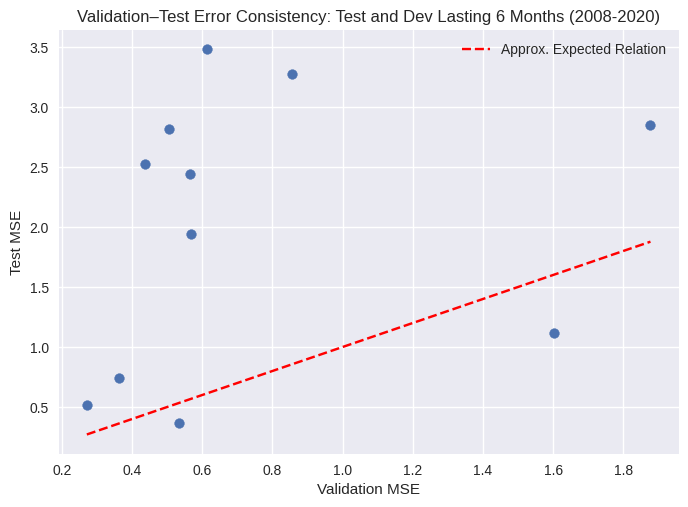

Text(0, 0.5, 'Average YoY Returns')

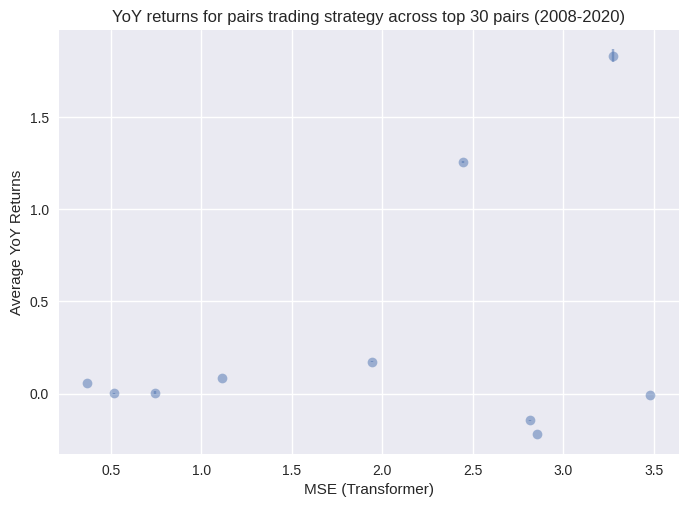

In [23]:
plt.title("Validation–Test Error Consistency: Test and Dev Lasting 6 Months (2008-2020)")
plt.xlabel("Validation MSE")
plt.ylabel("Test MSE")
# remove extremes: find all idx with MSE above 5
idx_to_remove = []
for i in range(len(val_mse_list)):
  if val_mse_list[i] > 5 or test_mse_list[i] > 5:
    idx_to_remove.append(i)
val_mse_list_clean = [val_mse_list[i] for i in range(len(val_mse_list)) if i not in idx_to_remove]
test_mse_list_clean = [test_mse_list[i] for i in range(len(test_mse_list)) if i not in idx_to_remove]
plt.scatter(val_mse_list_clean, test_mse_list_clean)
# plot y=x line (what we'd expect)
plt.plot([min(val_mse_list_clean), max(val_mse_list_clean)], [min(val_mse_list_clean), max(val_mse_list_clean)], color='red', linestyle='dashed', label='Approx. Expected Relation')
plt.legend()
plt.show()


idx_to_remove = []
for i in range(len(val_mse_list)):
  if test_mse_list[i] > 5 or return_list[i] > 5:
    idx_to_remove.append(i)
test_mse_list_clean2 = [test_mse_list[i] for i in range(len(test_mse_list)) if i not in idx_to_remove]
return_list_clean = [return_list[i] for i in range(len(return_list)) if i not in idx_to_remove]
return_std_list_clean = [return_std_list[i] for i in range(len(return_std_list)) if i not in idx_to_remove]
plt.errorbar(
      test_mse_list_clean2,
      return_list_clean,
      yerr=return_std_list_clean,
      fmt='o',
      alpha=0.5,
      capsize=3
      )
plt.title(f"YoY returns for pairs trading strategy across top 30 pairs (2008-2020)")
plt.xlabel("MSE (Transformer)")
plt.ylabel("Average YoY Returns")

In [26]:
# ('SHV', 'PDP') gives interesting results. Let's see why the return YoY is nan.

startDateStr = '2008-01-01'
endDateStr = '2020-12-31'
# test 2021/01-2021/12
startDateStrTest = '2020-01-01' # much shorter testing period this time
endDateStrTest = '2020-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data)
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

ticker_a, ticker_b = 'SHV', 'PDP'

pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)


pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
seed: int = 3178749 # for reproducibility, my student number
look_back: int = 20
batch_size: int = 64
epochs: int = 10
patience: int = 150
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = False
add_technical_indicators: bool = True
result_parent_dir: str = "data/results"
filename_base: str = "data_begindate_enddate_hash.pkl"
# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For GPU (if used)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_burned[:train_size]
dev   = pairs_timeseries_burned[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned[train_size+dev_size:]

train_multivariate = train.copy()
dev_multivariate   = dev.copy() # only for completeness
test_multivariate  = test.copy() # only for completeness

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

if denoise_fn is not None: # denoise using wavelet denoising
    train = pd.DataFrame({col: denoise_fn(train[col]) for col in train.columns}) # TODO: unsure whether dev and test should also be denoised?

x_scaler = scaler_factory(**scaler_kwargs) # important: the scaler learns parameters, so separate objects must be created for x and y
y_scaler = scaler_factory(**scaler_kwargs)

if not add_technical_indicators:
    train = train[[target_col]]
    dev = dev[[target_col]]
    test = test[[target_col]]

# We want a sliding window in our dataset
# TODO: defining this function should not be part of workflow, but imported from a custom module
def create_sliding_dataset(df: pd.DataFrame,
                          x_scaler: MinMaxScaler,
                          y_scaler: MinMaxScaler,
                          look_back: int = 20,
                          target_col: str = "Spread_Close",
                          fit_scaler: bool = False):
    """
    X  -> (samples, look_back, features)
    y  -> (samples, 1)   — the next-step Spread_Close (just 1 day in advance)
    """
    X, y = [], []
    for i in range(len(df) - look_back):
        X.append(df.iloc[i : i + look_back].values) # window
        y.append(df[target_col].iloc[i + look_back]) # value right after the window
    X, y = np.array(X), np.array(y).reshape(-1, 1)
    X_flat = X.reshape(-1, X.shape[-1])

    if fit_scaler: # only fit on the training set!
        X_scaled = x_scaler.fit_transform(X_flat).reshape(X.shape)
        y_scaled = y_scaler.fit_transform(y)
    else:
        X_scaled = x_scaler.transform(X_flat).reshape(X.shape)
        y_scaled = y_scaler.transform(y)

    return X, X_scaled, y, y_scaled

trainX_raw, trainX_scaled, trainY_raw, trainY_scaled = create_sliding_dataset(
    train, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = True) # train_X_scaled.shape: (2219, 20, 34) // [(t - look_back), look_back, features]
devX_raw,   devX_scaled,   devY_raw,   devY_scaled   = create_sliding_dataset(
    dev,  x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = False)
testX_raw,  testX_scaled,  testY_raw,  testY_scaled  = create_sliding_dataset(
    test, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back, target_col=target_col, fit_scaler = False)


# use pytorch Dataset class
class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        #  cast to float32 once to avoid repeated conversions
        self.X = torch.tensor(X, dtype=torch.float32)      # (N, L, F)
        self.y = torch.tensor(y, dtype=torch.float32)      # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]                    # each X: (L, F)

train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True,  drop_last=True,  num_workers=0)
dev_loader   = DataLoader(dev_ds,   batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)


class TimeSeriesTransformerv1(nn.Module):
  """
  This version (v1) uses:
  * learnable positional embeddings (simple, so no RoPE and no sinusoidal)
  * only an encoder (followed by a regression head that transforms from form (seq_len, d_model) into (1), with the output form being the Spread_Close prediction)
  """
  def __init__(
      self,
      n_features: int,
      seq_len: int,
      d_model: int = 128,
      nhead: int = 8,
      num_layers: int = 4,
      dropout: float = 0.1,
  ):
      super().__init__()
      self.seq_len = seq_len

      # token projection (linear layer)
      self.input_proj = nn.Linear(n_features, d_model)

      # learnable positional embedding  (1, seq_len, d_model)
      self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

      # encoder (important part)
      enc_layer = nn.TransformerEncoderLayer(
          d_model=d_model,
          nhead=nhead,
          dim_feedforward=d_model * 4,
          dropout=dropout,
          batch_first=True, # keeps (batch, seq, dim)
      )
      self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

      # regression head (mainly helps in getting to the right output format)
      self.head = nn.Sequential(
          nn.Flatten(start_dim=1), # (batch, seq_len*d_model)
          nn.Linear(seq_len * d_model, 128),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(128, 1),
      )

  def forward(self, x): # x: (batch, seq_len, n_features)
      x = self.input_proj(x) + self.pos_emb
      x = self.encoder(x) # (batch, seq_len, d_model)
      return self.head(x) # (batch, 1)

n_features = trainX_scaled.shape[-1]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model  = TimeSeriesTransformerv1(
            n_features=n_features,
            seq_len=look_back,
            d_model=128,
            nhead=8,
            num_layers=4,
            dropout=0.1).to(DEVICE)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

EPOCHS = epochs
PATIENCE = patience

# implement the early stopping logic manually
best_val = float("inf")
epochs_no_improve = 0
print_per_n = 10

# save train_loss and val_loss to lists for plotting
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x_batch).squeeze(-1)
        loss  = criterion(preds, y_batch.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
    train_losses.append(train_loss)

    model.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dev_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds  = model(x_batch).squeeze(-1)
            running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
    val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
    val_losses.append(val_loss)

    # print losses in a pretty way
    if epoch % print_per_n == 0:
      print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


    # manual early stopping logic
    if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
        best_val = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# Now, let's run the model on the testset
# made sure we're in eval mode
model.eval()

all_preds, all_targets = [], []
with torch.no_grad(): # note for myself: torch.no_grad() makes sure that individual weights are not stored in memory, because we would only need to know those during learning, not during inference
    for x_test_batch, y_test_batch in test_loader:
      x_test_batch = x_test_batch.to(DEVICE)
      preds = model(x_test_batch) # make predictions using model
      # transform the preds and targets back to numpy, as these need to be inverted with the scaler, which expects numpy not tensors
      preds = preds.cpu().numpy()
      y_test_batch = y_test_batch.cpu().numpy()
      all_preds.append(preds)
      all_targets.append(y_test_batch)

# Helper: Get preds/targets from dataloader, in scaled space
def get_preds_targets_scaled(dataloader, model, device):
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch).cpu().numpy()
            targets = y_batch.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)
    all_preds = np.concatenate(all_preds).reshape(-1, 1)
    all_targets = np.concatenate(all_targets).reshape(-1, 1)
    return all_preds, all_targets

## GETTING MSE's
# VAL (DEV)
val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
# Inverse-transform to original space
val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)
val_var = np.var(val_targets_orig)
val_nmse = val_mse_after_inverse / val_var # normalized mean squared error

# TEST
test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)
test_var = np.var(test_targets_orig)
test_nmse = test_mse_after_inverse / test_var

# maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
y_hat_scaled = np.concatenate(all_preds).reshape(-1, 1)
y_true_scaled = np.concatenate(all_targets).reshape(-1, 1)

y_hat = y_scaler.inverse_transform(y_hat_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

## Trading
test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
forecast_test_shortened_series = pd.Series(y_hat.squeeze(), index=test_index_shortened)
gt_test_shortened_series = pd.Series(y_true.squeeze(), index=test_index_shortened)

output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

## Trading: Mean YoY
min_position = 3.00
max_position = 3.50
min_clearing = 0.40
max_clearing = 0.50
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)


## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
# give same output as was originally the case
if add_technical_indicators:
  current_result_dir = filename_base.replace(".pkl", "_transformer")
else:
  current_result_dir = filename_base.replace(".pkl", "_transformer_without_ta")
result_dir = os.path.join(result_parent_dir, current_result_dir)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

Epoch 010 | train MSE 0.003731 | val MSE 0.011304


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 94 and the array at index 10 has size 93

In [25]:
for r in all_returns:
  print(len(r))

144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144


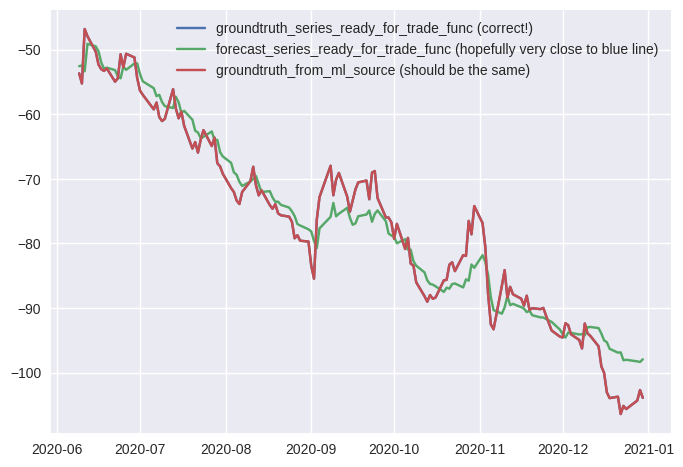

In [ ]:
# check whether forecast_test_shortened_series is really the form we'd want it to be
groundtruth_series_ready_for_trade_func = test_multivariate['Spread_Close'].iloc[look_back:]
forecast_series_ready_for_trade_func = pd.Series(
    y_hat.squeeze(),
    index=test_multivariate.index[look_back:]
)
groundtruth_from_ml_source = pd.Series(
    y_true.squeeze(),
    index=test_multivariate.index[look_back:]
)


# prediction_series_ready_for_trade_func = ...
plt.plot(groundtruth_series_ready_for_trade_func, label="groundtruth_series_ready_for_trade_func (correct!)") # This is the actual ground truth - the version of forecast_test_shortened should be as close to this as possible
plt.plot(forecast_series_ready_for_trade_func, label="forecast_series_ready_for_trade_func (hopefully very close to blue line)")
plt.plot(groundtruth_from_ml_source, label="groundtruth_from_ml_source (should be the same)")
plt.legend()

MSE: 10.788798332214355


(array([[-53.674145],
        [-55.24321 ],
        [-46.81399 ],
        [-47.917233],
        [-50.315357]], dtype=float32),
 array([[-52.562378],
        [-52.463   ],
        [-53.36343 ],
        [-49.104984],
        [-49.495293]], dtype=float32))

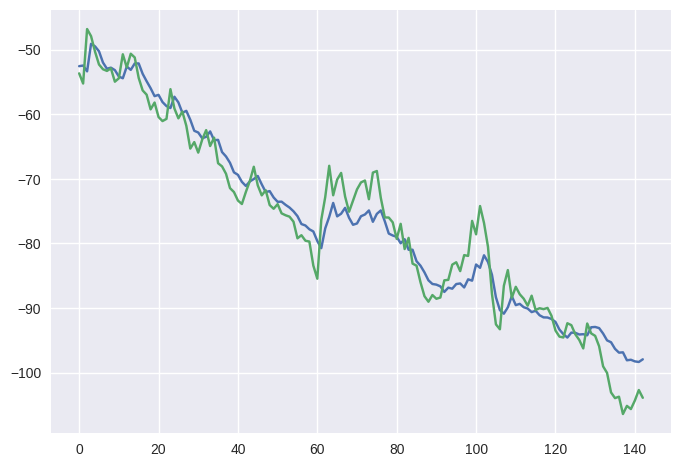

In [ ]:
# Test MSE cannot be correct.
# test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
# test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
# test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
# test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
# test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)
plt.plot(test_preds_orig)
plt.plot(test_targets_orig)
# import mean squared error from scipy
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_targets_orig, test_preds_orig)
print(f"MSE: {mse}")
test_targets_orig[:5], test_preds_orig[:5]

In [ ]:
output: Dict[str, Any] = dict(
    val_mse=val_mse_after_inverse,
    test_mse=test_mse_after_inverse,
    yoy_mean=yoy_mean,
    yoy_std=yoy_std,
    gt_yoy=gt_yoy,
    result_parent_dir=result_parent_dir,
)

results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
"""
print(results_str)


Validation MSE: 59.75531005859375
Test MSE: 12.5626859664917
YOY Returns: 833.29%
YOY Std: +- 9.19%
GT Yoy: 34.95%
Plot filepath parent dir: data/results



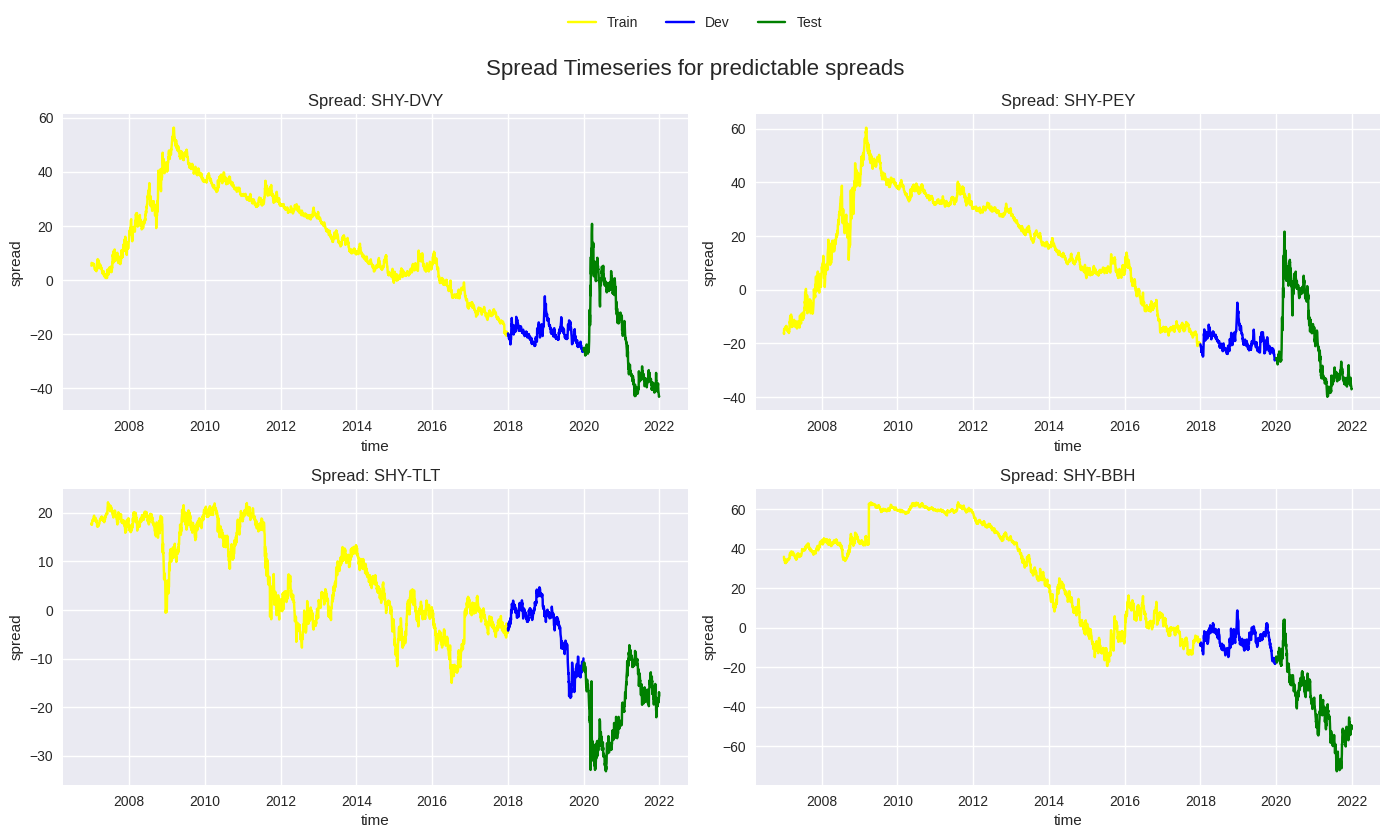

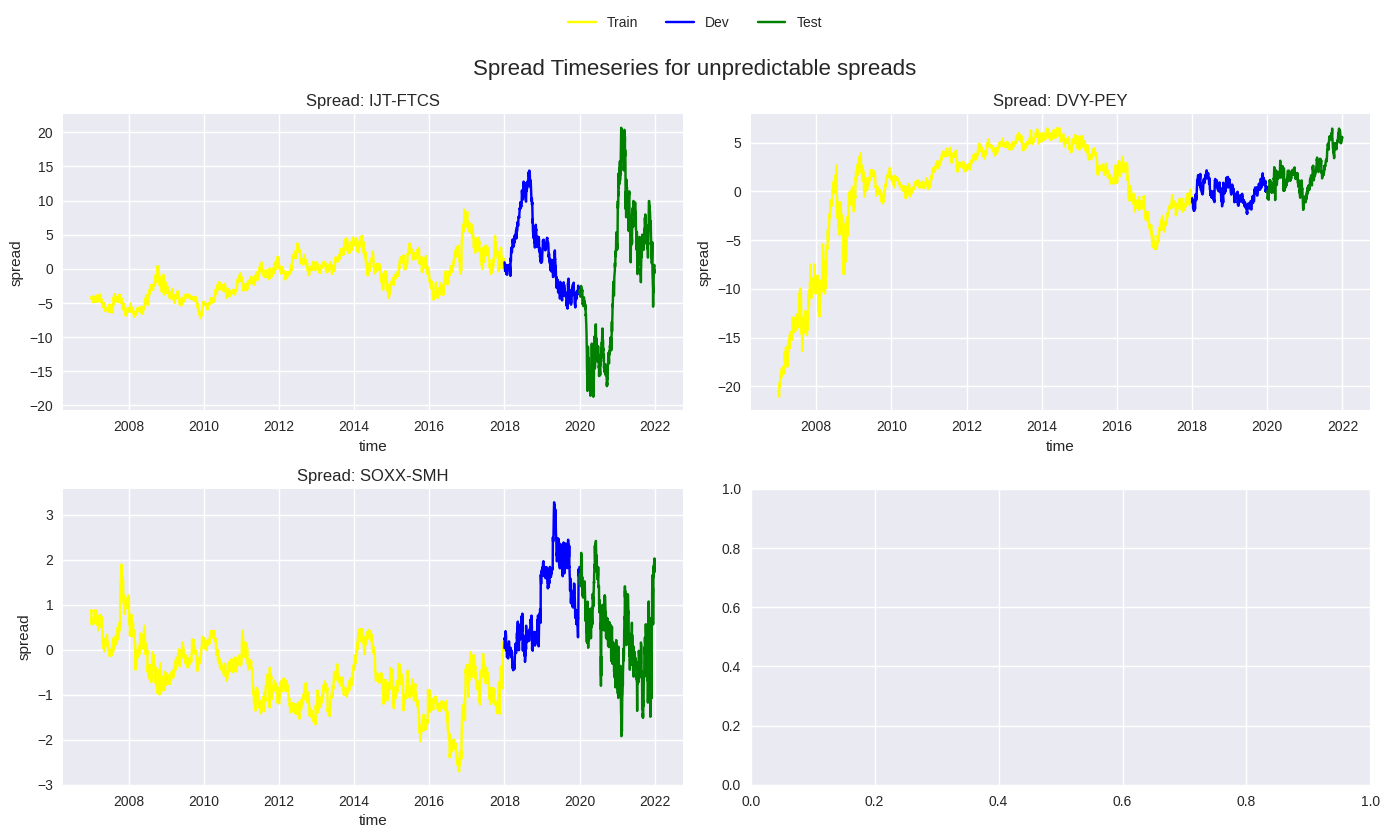

In [ ]:
# Let's try and get the results, just using some other pairs.
for i in range(len(pairs_data_filtered)):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  # plot the spread_close timeseries for each one

  # output = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE) + f"({ticker_a},{ticker_b})", pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=150)

predictable_iters = [1,2,4,5]
unpreditable_iters = [0, 3, 6]

import matplotlib.lines as mlines

train_line = mlines.Line2D([], [], color='yellow', label='Train')
dev_line = mlines.Line2D([], [], color='blue', label='Dev')
test_line = mlines.Line2D([], [], color='green', label='Test')

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for idx, predictable_iter in enumerate(predictable_iters):
    row, col = divmod(idx, 2)
    ticker_a, ticker_b = pairs_data_filtered[predictable_iter][0][0], pairs_data_filtered[predictable_iter][0][1]
    pairs_timeseries_df = combine_pairs_data(
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2,
        data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b
    )
    target_timeseries = pairs_timeseries_df['Spread_Close']
    # train_frac, dev_frac
    # test_frac = 1 - train_frac - dev_frac
    train_len = int(len(target_timeseries) * train_frac)
    dev_len = int(len(target_timeseries) * dev_frac)
    test_len = len(target_timeseries) - train_len - dev_len
    ax[row, col].plot(target_timeseries[:train_len], color="yellow")
    ax[row, col].plot(target_timeseries[train_len:train_len + dev_len], color="blue")
    ax[row, col].plot(target_timeseries[train_len + dev_len:], color="green")
    ax[row, col].set_title(f"Spread: {ticker_a}-{ticker_b}")
    ax[row, col].set_xlabel("time")
    ax[row, col].set_ylabel("spread")
fig.suptitle("Spread Timeseries for predictable spreads", fontsize=16)
fig.legend(handles=[train_line, dev_line, test_line], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))


plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for idx, unpredictable_iter in enumerate(unpreditable_iters):
    row, col = divmod(idx, 2)
    ticker_a, ticker_b = pairs_data_filtered[unpredictable_iter][0][0], pairs_data_filtered[unpredictable_iter][0][1]
    pairs_timeseries_df = combine_pairs_data(
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2,
        data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b
    )
    target_timeseries = pairs_timeseries_df['Spread_Close']
    train_len = int(len(target_timeseries) * train_frac)
    dev_len = int(len(target_timeseries) * dev_frac)
    test_len = len(target_timeseries) - train_len - dev_len
    ax[row, col].plot(target_timeseries[:train_len], color="yellow")
    ax[row, col].plot(target_timeseries[train_len:train_len + dev_len], color="blue")
    ax[row, col].plot(target_timeseries[train_len + dev_len:], color="green")
    ax[row, col].set_title(f"Spread: {ticker_a}-{ticker_b}")
    ax[row, col].set_xlabel("time")
    ax[row, col].set_ylabel("spread")
# give title to whole fig
fig.suptitle("Spread Timeseries for unpredictable spreads", fontsize=16)
fig.legend(handles=[train_line, dev_line, test_line], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

In [ ]:
output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
output

{'gt_yoy_test': np.float64(-0.009269780597999211),
 'gt_yoy_dev': np.float64(-0.07888546803510088)}

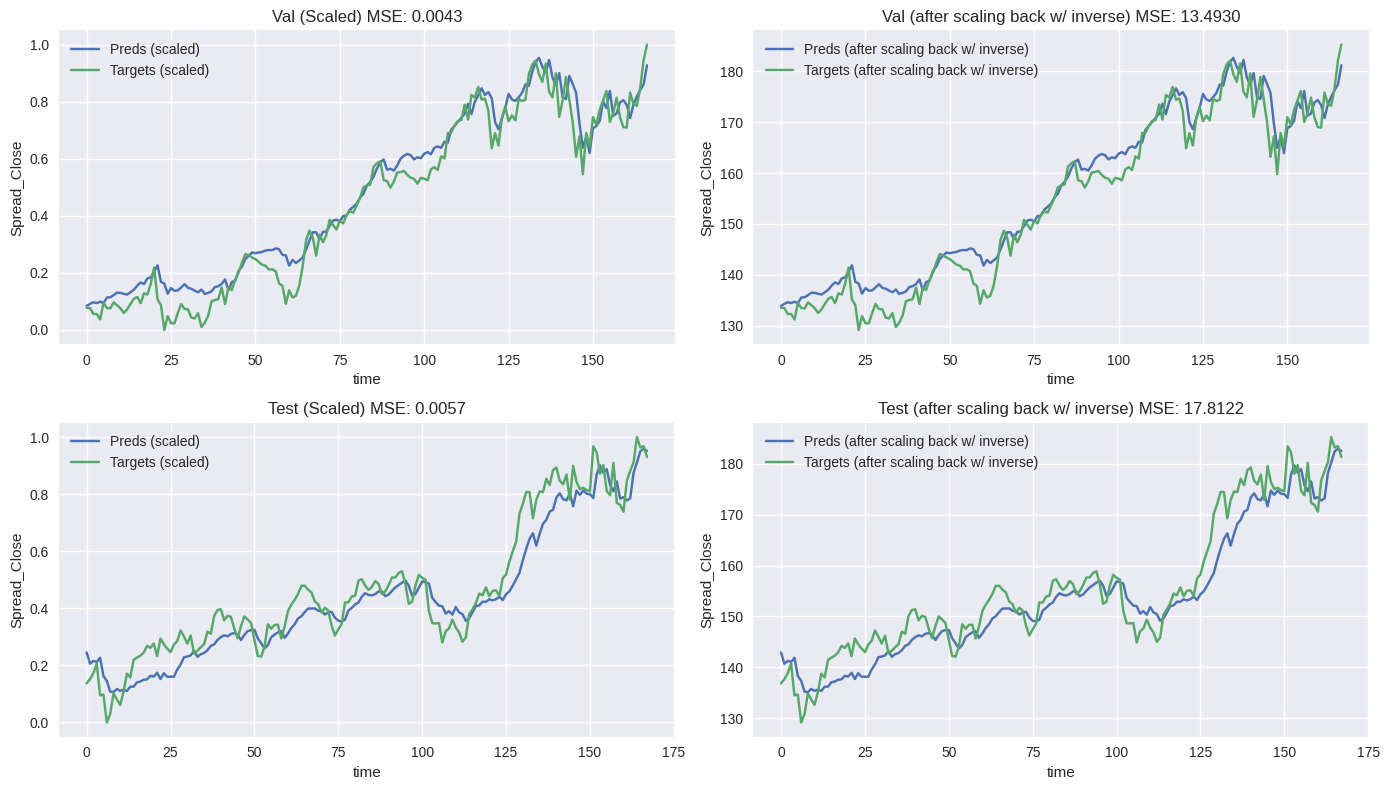

In [ ]:
# # VAL (DEV)
# val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
# val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
# # Inverse-transform to original space
# val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
# val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
# val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)

# # TEST
# test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
# test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
# test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
# test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
# test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# 1. val scaled
axs[0, 0].plot(val_preds_scaled, label='Preds (scaled)')
axs[0, 0].plot(val_targets_scaled, label='Targets (scaled)')
axs[0, 0].set_xlabel("time")
axs[0, 0].set_ylabel("Spread_Close")
axs[0, 0].set_title(f"Val (Scaled) MSE: {val_mse_before_inverse:.4f}")
axs[0, 0].legend()

# 2. val after inverse
axs[0, 1].plot(val_preds_orig, label='Preds (after scaling back w/ inverse)')
axs[0, 1].plot(val_targets_orig, label='Targets (after scaling back w/ inverse)')
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("Spread_Close")
axs[0, 1].set_title(f"Val (after scaling back w/ inverse) MSE: {val_mse_after_inverse:.4f}")
axs[0, 1].legend()

# 3. test mse before inverse
axs[1, 0].plot(test_preds_scaled, label='Preds (scaled)')
axs[1, 0].plot(test_targets_scaled, label='Targets (scaled)')
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("Spread_Close")
axs[1, 0].set_title(f"Test (Scaled) MSE: {test_mse_before_inverse:.4f}")
axs[1, 0].legend()

# 4. test mse after inverse
axs[1, 1].plot(test_preds_orig, label='Preds (after scaling back w/ inverse)')
axs[1, 1].plot(test_targets_orig, label='Targets (after scaling back w/ inverse)')
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("Spread_Close")
axs[1, 1].set_title(f"Test (after scaling back w/ inverse) MSE: {test_mse_after_inverse:.4f}")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

To get a more reliable plot, we will test out a set of different threshold combinations to be able to plot uncertainty / standard deviation in our returns.



Some examples of outputs for understanding the form of the data better:

`len(trainX_untr)`
```
2238
```

`len(trainX_untr[0])`
```
34
```

Context: The 34 features consist of
* 10 technical indicators for both S1 and S2 (total 20)
* S1_close/open/high/low/volume, same for S2 (total 10)
* Pair spreads: close, open, high, low (total 4)


`trainX_untr[0] `
```
array([ 2.76970068e+01,  4.91006247e+01,  2.89730484e+01,  4.91027293e+01,
        2.89891358e+01,  4.91343834e+01,  2.60513431e+01,  4.87784465e+01,
        5.03546207e+05,  7.43386097e+03,  4.49718063e+01,  5.82671806e+01,
        5.75577766e+01,  8.28358144e+01,  7.59406546e+01,  3.92425336e+02,
        1.05376719e+05, -9.14930577e+03,  1.56861725e+00,  7.63660812e-01,
        2.85638197e+01,  4.83799321e+01,  8.30115861e+00,  2.65305580e+01,
        2.84687992e+01,  4.85740999e+01,  2.27306259e-01,  4.38795633e-02,
       -1.31033890e+00,  1.00654755e-01, -6.89227038e+00, -5.61453974e+00,
       -5.72867758e+00, -8.18838280e+00])
```

`len(trainY_untr)`
```
2238
```


`len(trainY_untr)[0]`
```
1
```

`trainY_untr[0]`
```
array([27.81830352])
```

`trainY_untr[:20]`
```
[array([27.81830352]),
 array([27.42025825]),
 array([25.9191175]),
 array([22.98625305]),
 array([20.5661885]),
 array([21.23151271]),
 array([24.11603916]),
 array([25.605551]),
 array([26.16966699]),
 array([26.46204422]),
 array([25.33065673]),
 array([25.72835342]),
 array([25.91998167]),
 array([25.70591191]),
 array([25.83366537]),
 array([26.33152235]),
 array([26.35160811]),
 array([26.2352556]),
 array([26.03820719]),
 array([25.75521362])]
 ```

`trainX_sliding.shape` (when using look_back=20)

```
 (2219, 20, 34)
```
